# **Watermelon Sweetness Image Classification CNN Model**
### **Author:** Tanner Rapp
### **Data Source:** Capstonesementara. Sweetness: Watermelon [dataset]. Roboflow Universe. Available at: https://universe.roboflow.com/capstonesementara/sweetness-watermelon

##### **-----Load Libraries--------------------------------------------------------------------------------------------------------------------------**

In [115]:
#pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split



##### **-----Load Data--------------------------------------------------------------------------------------------------------------------------**

Read in classification csv.

In [2]:
path = r"C:\Users\tanne\OneDrive\Desktop\Fun Statistical Coding Practice\Watermelon Sweetness Classification\_classes.csv"
classes = pd.read_csv(path)
classes.head() 

,filename,manis,tidak_manis
0,unripe-214-_jpg.rf.84407fbbe987582fcc0106bf1f3...,0,1
1,unripe-763-_jpg.rf.72545844b4bc5e4f0bd2e0ac742...,0,1
2,ripe-234-Copy_jpg.rf.5f33944728f81096afd84ff52...,1,0
3,ripe-1312-Copy_jpg.rf.820ab2d9adca03033607593b...,1,0
4,ripe-1778-_jpg.rf.67d60eb380dce598334e876326f9...,0,1


Read in watermelon images.

In [3]:
images = r"C:\Users\tanne\OneDrive\Desktop\Fun Statistical Coding Practice\Watermelon Sweetness Classification\all_pics"

##### **-----Model Architecture ------------------------------------------------------------------------------------------------------------------**

"Manis" is Indonesian for "Sweet".

In [4]:
classes["sweet"] = classes[" manis"]

Check if there is a class imbalance.

In [5]:
classes['sweet'].value_counts()

sweet
1    72
0    68
Name: count, dtype: int64

The above shows approximately equal value counts of each class. I'll use this to justify no stratification when splitting into training and testing data.

Split data into train, test and validation data sets.

In [6]:
y_data = classes['sweet']
x_data=classes['filename']

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.30, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

Preprocess images.

In [7]:
from pathlib import Path

# x_train and x_test are just file names. I need to let the algorithm know which images it can search for to properly separate into train/test. 
base_dir = Path(images)

# now join file names with base_dir
x_train = [str(base_dir / fname) for fname in x_train]
x_test  = [str(base_dir / fname) for fname in x_test]
x_val  = [str(base_dir / fname) for fname in x_val]

Sanity check: ensure files exist and that no images overlap from training and test data sets.

In [9]:
missing = [p for p in x_train + x_val if not Path(p).is_file()]
if missing:
    raise FileNotFoundError(f"Missing files (first 5 shown): {missing[:5]}")

if set(x_train).isdisjoint(x_test):
    print("They don't share any values")
else:
    print("They share at least one value")

They don't share any values


In [10]:
# --- Config ---
img_size   = (224, 224)   # Resize target
batch= 32

# --- Helper to load and preprocess ---
def load_image(path, label):
    img = tf.io.read_file(path)                              # Read file
    img = tf.io.decode_image(img, channels=3, expand_animations=False)  
    img = tf.image.resize(img, img_size)                     # Resize
    img = tf.cast(img, tf.float32) / 255.0                   # Scale [0,1]
    return img, label

def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, shuffle=True)
test_ds  = make_dataset(x_test,  y_test,  shuffle=False)
val_ds = make_dataset(x_val, y_val, shuffle=False)

Check that the images are being read in.

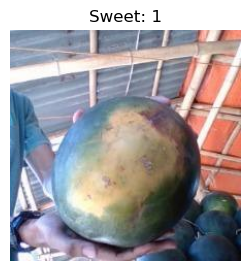

In [12]:
for images, labels in train_ds.take(1):
    img = images[0].numpy()      # first image in the batch
    label = labels[0].numpy()    # its label
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.title(f"Sweet: {label}")
plt.axis("off")
plt.show()

##### **-----Model Architecture ------------------------------------------------------------------------------------------------------------------**

In [28]:
# define cnn classification model
def classification_model_cnn():
    # create model
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))
    model.add(layers.Rescaling(1./255))
    
    model.add(layers.Conv2D(32, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(128, 3, padding="same", activation="relu"))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(256, 3, padding="same", activation="relu"))
    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.1)) 
    model.add(layers.Dense(1, activation="sigmoid"))   # binary classification
    
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# build the cnn model
model = classification_model_cnn()
model.summary() 

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,441 (1.61 MB)

 Trainable params: 421,441 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

##### **-----Model Fit & Evaluation------------------------------------------------------------------------------------------------------------------**

I am trying out both a CNN and a Dense model. See results below to see which performed better. 

Epoch 1/20
4/4 - 4s - 881ms/step - accuracy: 0.4592 - loss: 0.6934 - val_accuracy: 0.3810 - val_loss: 0.6936
Epoch 2/20
4/4 - 2s - 575ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.3810 - val_loss: 0.6946
Epoch 3/20
4/4 - 2s - 566ms/step - accuracy: 0.5000 - loss: 0.6934 - val_accuracy: 0.3810 - val_loss: 0.6942
Epoch 4/20
4/4 - 2s - 599ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.6190 - val_loss: 0.6927
Epoch 5/20
4/4 - 3s - 696ms/step - accuracy: 0.5102 - loss: 0.6933 - val_accuracy: 0.6190 - val_loss: 0.6920
Epoch 6/20
4/4 - 3s - 707ms/step - accuracy: 0.5000 - loss: 0.6934 - val_accuracy: 0.6190 - val_loss: 0.6919
Epoch 7/20
4/4 - 3s - 680ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.6190 - val_loss: 0.6926
Epoch 8/20
4/4 - 3s - 750ms/step - accuracy: 0.5102 - loss: 0.6932 - val_accuracy: 0.6190 - val_loss: 0.6931
Epoch 9/20
4/4 - 4s - 892ms/step - accuracy: 0.3776 - loss: 0.6933 - val_accuracy: 0.3810 - val_loss: 0.6932
Epoch 10/20
4/4 - 3

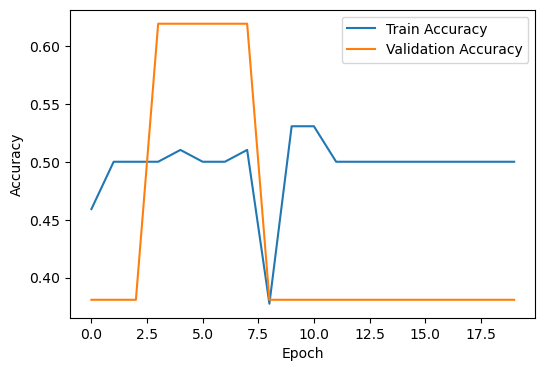

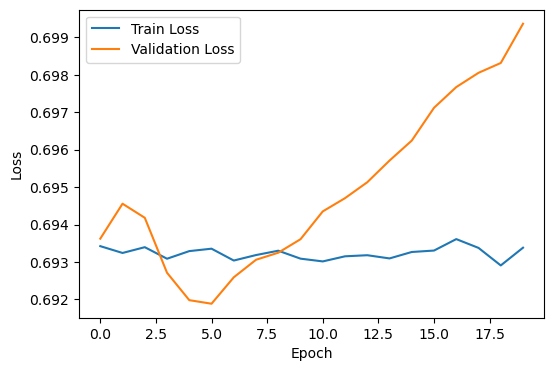

Accuracy: 0.523809552192688% 
 Error: 0.476190447807312


In [30]:
# fit the cnn model
model = classification_model_cnn()  # new weights
history = model.fit(train_ds, validation_data=(val_ds), epochs=20, verbose=2)

# Plot performance
h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['accuracy'], label = 'Train Accuracy')
plt.plot(h['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['loss'], label = 'Train Loss')
plt.plot(h['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate the model
scores = model.evaluate(test_ds, verbose=0)

print('Accuracy: {}% \n Error: {}'.format(scores[1], 1 - scores[1])) 

In [35]:
def classification_model_dense(): 
    # create dense model 
    model = Sequential() 
    model.add(Input(shape=(224, 224, 3))) 
    model.add(layers.Rescaling(1./255)) 
    model.add(layers.Flatten()) 
    model.add(Dense(512, activation='relu')) 
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(1, activation='sigmoid')) 
    
    # compile model 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model

# build the dense model
model = classification_model_dense()
model.summary() 

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_22 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,122,249 (294.20 MB)

 Trainable params: 77,122,249 (294.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 - 4s - 967ms/step - accuracy: 0.5000 - loss: 0.7175 - val_accuracy: 0.4762 - val_loss: 0.6862
Epoch 2/20
4/4 - 3s - 720ms/step - accuracy: 0.6939 - loss: 0.5946 - val_accuracy: 0.7619 - val_loss: 0.5685
Epoch 3/20
4/4 - 3s - 701ms/step - accuracy: 0.7653 - loss: 0.4705 - val_accuracy: 0.6190 - val_loss: 0.6000
Epoch 4/20
4/4 - 3s - 721ms/step - accuracy: 0.8061 - loss: 0.4597 - val_accuracy: 0.6190 - val_loss: 0.7228
Epoch 5/20
4/4 - 3s - 761ms/step - accuracy: 0.7551 - loss: 0.5446 - val_accuracy: 0.6190 - val_loss: 0.5539
Epoch 6/20
4/4 - 3s - 747ms/step - accuracy: 0.7551 - loss: 0.5564 - val_accuracy: 0.8571 - val_loss: 0.4463
Epoch 7/20
4/4 - 5s - 1s/step - accuracy: 0.8061 - loss: 0.4173 - val_accuracy: 0.6667 - val_loss: 0.7499
Epoch 8/20
4/4 - 3s - 728ms/step - accuracy: 0.7959 - loss: 0.4531 - val_accuracy: 0.6190 - val_loss: 0.5188
Epoch 9/20
4/4 - 3s - 736ms/step - accuracy: 0.8163 - loss: 0.3996 - val_accuracy: 0.6667 - val_loss: 0.4899
Epoch 10/20
4/4 - 3s -

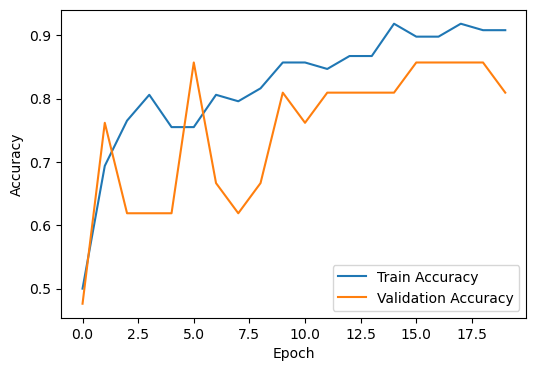

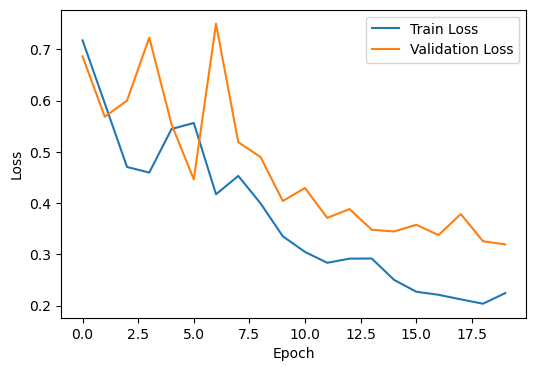

Accuracy: 0.9047619104385376% 
 Error: 0.0952380895614624


In [37]:
# fit the dense model
model = classification_model_dense()  # new weights
history = model.fit(train_ds, validation_data=(val_ds), epochs=20, verbose=2)

# Plot performance
h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['accuracy'], label = 'Train Accuracy')
plt.plot(h['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['loss'], label = 'Train Loss')
plt.plot(h['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluate the model
scores = model.evaluate(test_ds, verbose=0)

print('Accuracy: {}% \n Error: {}'.format(scores[1], 1 - scores[1])) 

##### **-----Take Away ------------------------------------------------------------------------------------------------------------------**

When I compared my CNN and dense models, I noticed that the dense model performed much better. The CNN basically hovered around random guessing, with validation loss steadily increasing, while the dense model quickly climbed to about 90% training accuracy and 85–88% validation accuracy with much lower loss. I think this happened because the dense model has so many parameters that it can pick up on global cues in the data, like color or brightness, whereas my CNN was too shallow and only focused on local features. At the same time, I know the dense model’s strong performance might also mean it’s overfitting or learning shortcuts, so I need to be careful with regularization and validation. Ideally, a well-tuned CNN or a transfer learning approach should generalize better.